In [15]:
import pandas as pd
import pandas_ta as pta
import numpy as np
import os
import pickle

from config import BASE_DIR
print(os.getcwd())
os.chdir(BASE_DIR)
from scripts.backtesting.backtesting import Strategy, Backtest 
from scripts.backtesting.lib import resample_apply
from ta.volatility import BollingerBands
import scripts.functions as fn 

C:\Users\lbisa\Dropbox\Cripto\python\InvestingEvolution\ie\www


In [16]:
klines_file = './backtest/klines/2d01/Completo_BTCUSDT_2d01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m15/Completo_XRPUSDT_0m15_2021-01-01_2023-07-31.DataFrame'
#klines_file  = './backtest/klines/0m01/Completo_BTCUSDT_0m01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/0m01/Lateral_BTCUSDT_0m01_2023-06-20_2023-10-09.DataFrame'
#klines_file  = './backtest/klines/1h01/Completo_BTCUSDT_1h01_2021-01-01_2023-07-31.DataFrame'
#klines_file = './backtest/klines/1h01/Lateral_BTCUSDT_1h01_2023-06-20_2023-10-09.DataFrame'
#klines_file = './backtest/klines/1h01/Bajista_BTCUSDT_1h01_2021-04-12_2021-07-12.DataFrame'
#klines_file  = './backtest/klines/1h04/Completo_BTCUSDT_1h04_2021-01-01_2023-07-31.DataFrame'

with open(klines_file, 'rb') as file:
    df = pickle.load(file)
    #data.set_index('datetime',inplace=True)


In [17]:
df.ta.supertrend(period=7, multiplier=3, append=True)
df.tail(5)


,datetime,open,high,low,close,volume,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0
1147,2023-07-28,29222.78,29542.22,29123.12,29314.14,23993.61627,28353.943594,1,28353.943594,NaN
1148,2023-07-29,29314.14,29406.92,29256.18,29352.90,10851.36844,28353.943594,1,28353.943594,NaN
1149,2023-07-30,29352.90,29449.00,29033.24,29281.09,15706.97441,28353.943594,1,28353.943594,NaN
1150,2023-07-31,29281.09,29530.00,29101.80,29232.25,22605.48964,28353.943594,1,28353.943594,NaN
1151,2023-08-01,29232.26,29739.25,28585.70,29705.99,44719.65162,28353.943594,1,28353.943594,NaN


<Axes: >

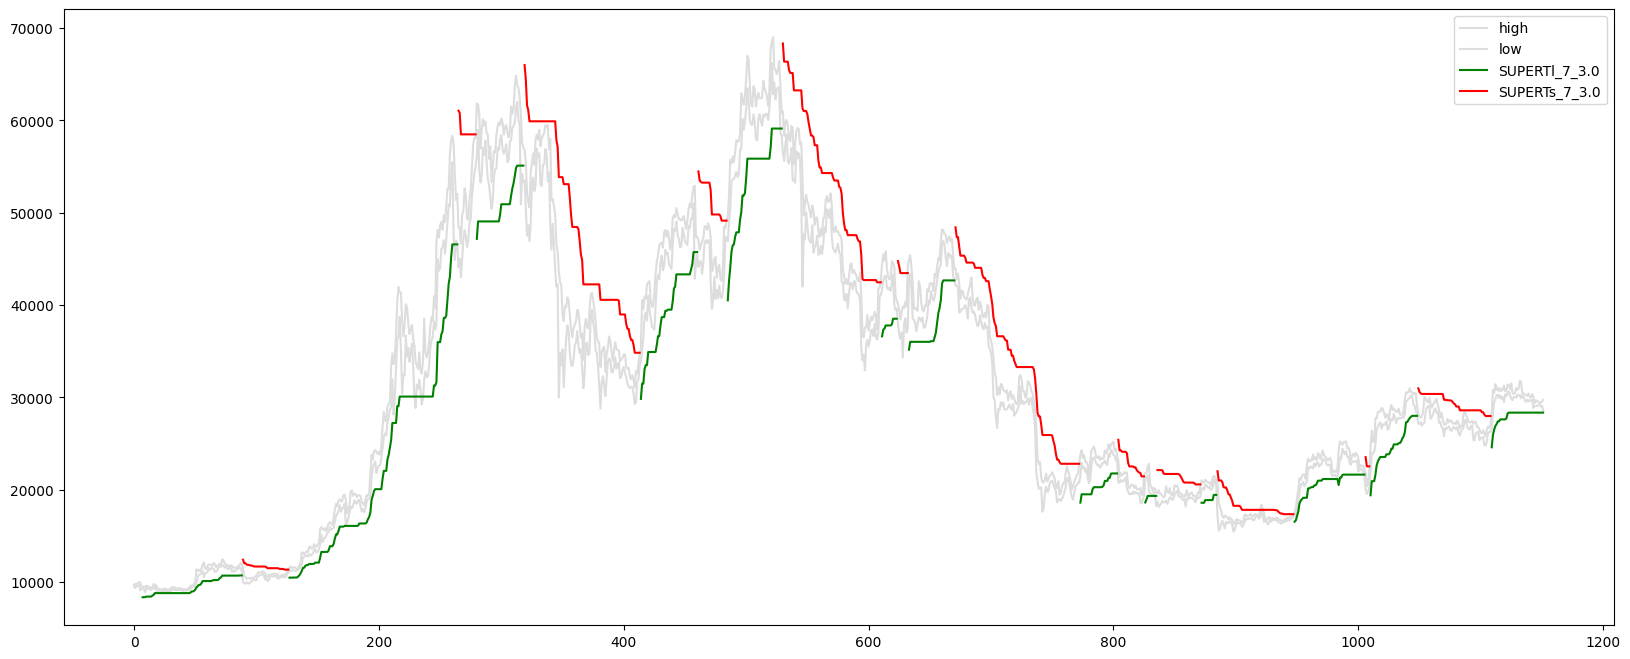

In [19]:
df[['high','low','SUPERTl_7_3.0','SUPERTs_7_3.0']].plot(figsize=(20,8),style=['#dddddd','#dddddd','g','r'])